<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/work/err/RS/Rel_Strength.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
# 1. Nifty 50 stocks list (Yahoo Finance symbols)
nifty_50 = [
    "RELIANCE.NS", "TCS.NS", "INFY.NS", "HDFCBANK.NS", "ICICIBANK.NS", "ITC.NS",
    "LT.NS", "KOTAKBANK.NS", "SBIN.NS", "HINDUNILVR.NS", "BHARTIARTL.NS", "ASIANPAINT.NS",
    "AXISBANK.NS", "MARUTI.NS", "SUNPHARMA.NS", "BAJFINANCE.NS", "WIPRO.NS", "HCLTECH.NS",
    "ULTRACEMCO.NS", "ONGC.NS", "NTPC.NS", "NESTLEIND.NS", "POWERGRID.NS", "JSWSTEEL.NS",
    "TITAN.NS", "GRASIM.NS", "ADANIENT.NS", "ADANIPORTS.NS", "TATAMOTORS.NS", "DRREDDY.NS",
    "DIVISLAB.NS", "BAJAJFINSV.NS", "BPCL.NS", "BRITANNIA.NS", "EICHERMOT.NS", "COALINDIA.NS",
    "SBILIFE.NS", "CIPLA.NS", "HEROMOTOCO.NS", "INDUSINDBK.NS", "HDFCLIFE.NS", "BAJAJ-AUTO.NS",
    "TECHM.NS", "TATASTEEL.NS", "HINDALCO.NS", "UPL.NS", "APOLLOHOSP.NS", "M&M.NS", "ICICIPRULI.NS",
    "SHREECEM.NS"
]

# 2. Download Nifty 50 Index (^NSEI) price
index_symbol = '^NSEI'
start_date = '2024-06-01'
end_date = '2025-06-15'

index_data = yf.download(index_symbol, start=start_date, end=end_date)
index_close = index_data['Close']



def compute_momentum(stock_symbol, index_symbol, start_date, end_date,
                     lookback_days=126):  # ~6 months (252 trading days ~ 1 year)
    """
    Returns:
      - rs_normalized: pandas.Series of (stock_adj / index_adj) normalized to 1 at start_date
      - momentum_score: float -> percent outperformance over lookback_days (stock_ret - index_ret)
      - rs_zscore: float -> z-score of RS over the available series (optional)
    """
    try:
        # download adjusted closes only
        tickers = [stock_symbol, index_symbol]
        data = yf.download(tickers, start=start_date, end=end_date, progress=False)['Close']
        # If single column returned for one symbol, wrap it
        if isinstance(data, pd.Series):
            data = data.to_frame(tickers[0])
        # rename for clarity
        data = data.rename(columns={stock_symbol: 'Stock', index_symbol: 'Index'})
        data = data[['Stock', 'Index']].dropna()

        if data.empty or len(data) < 2:
            raise ValueError("Not enough data for computation.")

        # RS series and normalized
        rs = data['Stock'] / data['Index']
        rs_normalized = rs / rs.iloc[0]

        # If lookback longer than available data, adjust
        lookback_days = min(lookback_days, len(data) - 1)

        # compute lookback returns (total return over lookback_days)
        stock_ret = data['Stock'].iloc[-1] / data['Stock'].iloc[-1 - lookback_days] - 1
        index_ret = data['Index'].iloc[-1] / data['Index'].iloc[-1 - lookback_days] - 1

        # relative momentum (outperformance)
        momentum_score = (stock_ret - index_ret)  # positive => outperformed index

        # z-score of RS over its history (optional signal for extremeness)
        rs_mean = rs.mean()
        rs_std  = rs.std(ddof=0) if rs.std(ddof=0) != 0 else np.nan
        rs_zscore = (rs.iloc[-1] - rs_mean) / rs_std if pd.notnull(rs_std) else np.nan

        return {
            'rs_normalized': rs_normalized,
            'momentum_score': momentum_score,
            'stock_ret': stock_ret,
            'index_ret': index_ret,
            'rs_zscore': rs_zscore,
            'data': data
        }

    except Exception as e:
        print(f"Error for {stock_symbol}: {e}")
        return None


# 4. Loop over all Nifty 50 stocks and calculate RS
rs_dict = {}

print("Calculating RS for Nifty 50 stocks...")
for symbol in tqdm(nifty_50):
    rs = compute_momentum(symbol,index_symbol,start_date,end_date)
    if rs is not None and len(rs) > 0:
        rs_dict[symbol] = rs

# 5. Create a DataFrame of last RS values (latest day)
latest_rs = {symbol: res['rs_normalized'].iloc[-1]
             for symbol, res in rs_dict.items() if res is not None}

latest_rs_df = pd.DataFrame.from_dict(latest_rs, orient='index', columns=['Latest RS'])
latest_rs_df = latest_rs_df.sort_values(by='Latest RS', ascending=False)


# 6. Display Top 10 Outperformers
print("\nTop 10 Relative Strength Performers (vs Nifty):")
print(latest_rs_df.head(10))



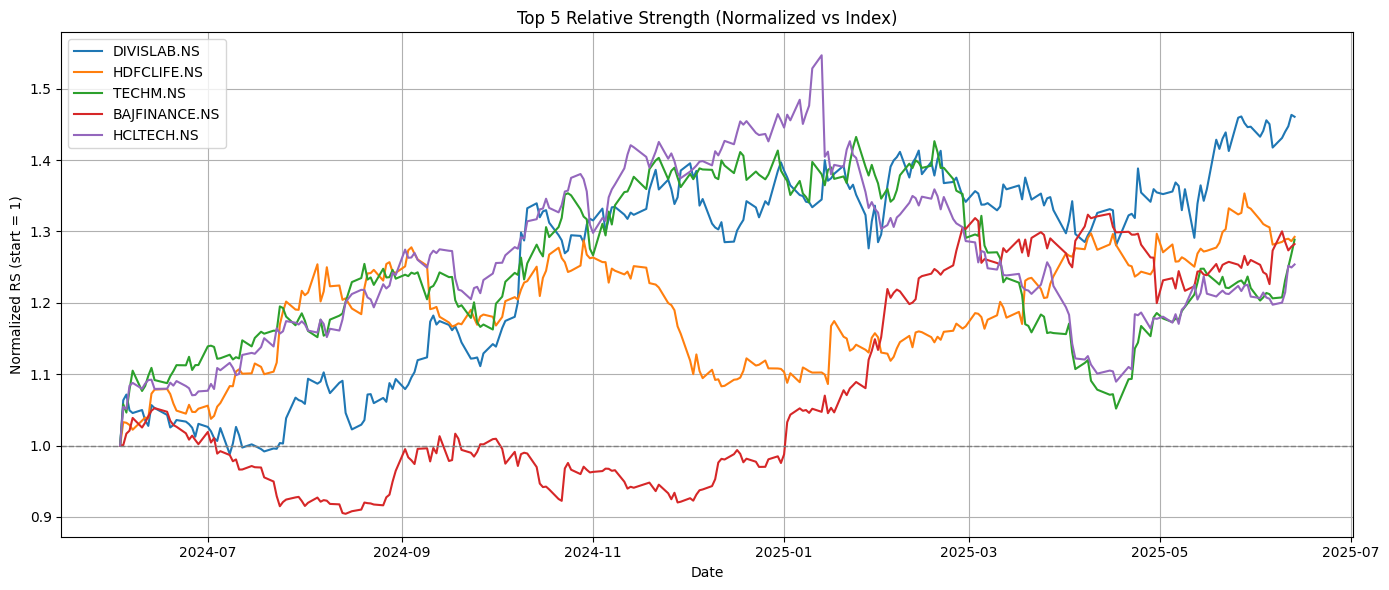

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

def _extract_rs_series(value):
    """
    Return a pandas Series for the RS normalized series, or None if unavailable.
    Accepts:
      - a pd.Series (already the normalized RS)
      - a dict with key 'rs_normalized' (value should be a Series)
      - otherwise returns None
    """
    if value is None:
        return None
    if isinstance(value, pd.Series):
        return value
    if isinstance(value, dict) and 'rs_normalized' in value:
        return value['rs_normalized']
    return None

# Build latest RS dict safely
latest_rs = {}
for symbol, v in rs_dict.items():
    series = _extract_rs_series(v)
    if series is None:
        continue
    # ensure non-empty series
    if len(series) == 0:
        continue
    # take last valid value (works even if last few rows are NaN)
    last_valid_idx = series.last_valid_index()
    if last_valid_idx is None:
        continue
    latest_rs[symbol] = series.loc[last_valid_idx]

if not latest_rs:
    raise ValueError("No valid RS series found in rs_dict.")

# Create DataFrame and sort
latest_rs_df = pd.DataFrame.from_dict(latest_rs, orient='index', columns=['Latest RS'])
latest_rs_df = latest_rs_df.sort_values(by='Latest RS', ascending=False)

# Pick top 3 (or fewer if less than 3 symbols available)
top_n = 5
top_symbols = latest_rs_df.head(top_n).index.tolist()

# Plot top N RS normalized series
plt.figure(figsize=(14, 6))
for symbol in top_symbols:
    series = _extract_rs_series(rs_dict[symbol])
    if series is None or len(series.dropna()) == 0:
        continue
    # plot using index for x-axis (dates) and values for y-axis
    plt.plot(series.index, series.values, label=symbol)

plt.axhline(1, color='gray', linestyle='--', linewidth=1)
plt.title(f'Top {len(top_symbols)} Relative Strength (Normalized vs Index)')
plt.xlabel('Date')
plt.ylabel('Normalized RS (start = 1)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/tmp/ipython-input-3202143446.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start, end=end, progress=False)['Close']


Buy & Hold final value: 0.9529359139048672
Monthly rebalance final value: 1.0000000000000002


/tmp/ipython-input-3202143446.py:56: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rebalance_dates = prices.resample(rebalance_freq).last().index


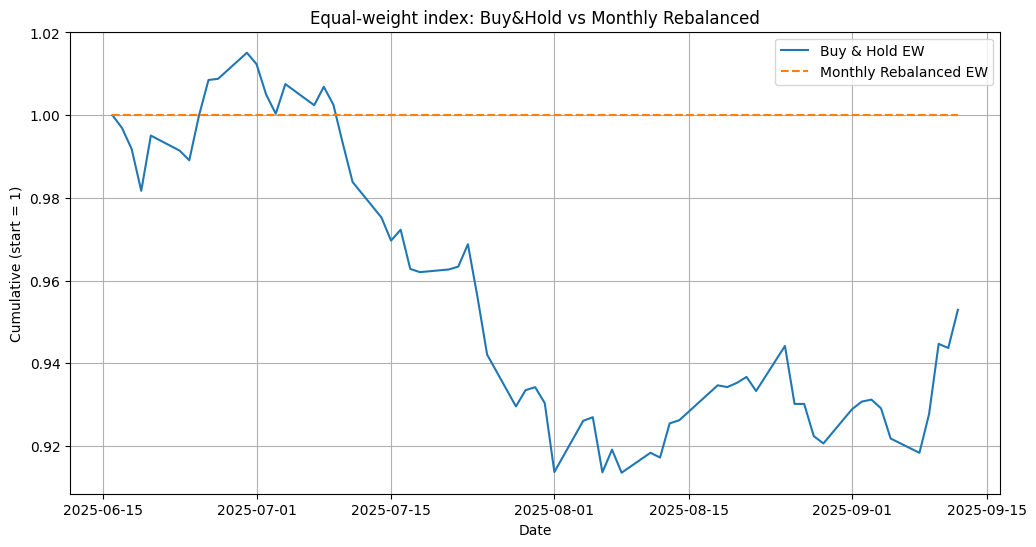

In [15]:
def fetch_adjclose(tickers, start, end):
    """Fetch adjusted close prices for tickers and return aligned DataFrame."""
    data = yf.download(tickers, start=start, end=end, progress=False)['Close']
    # if single ticker, make DataFrame
    if isinstance(data, pd.Series):
        data = data.to_frame()
    data = data.dropna(how='all')  # drop days with no prices for all tickers
    return data

def equal_weight_portfolio(adjclose, rebalance_freq=None, initial_capital=1.0):
    """
    adjclose : DataFrame (dates x tickers) of adjusted closes
    rebalance_freq : None for buy&hold, or 'M' for month-end, 'W' weekly, or integer days (e.g., 21)
    initial_capital : starting portfolio value (float)

    Returns: dict with
      - 'weights': DataFrame of daily weights
      - 'position_values': DataFrame of dollar value by asset
      - 'portfolio_value': Series of total portfolio value
      - 'returns': daily returns of portfolio
    """
    prices = adjclose.sort_index()
    tickers = prices.columns.tolist()
    n = len(tickers)
    # Compute daily returns
    daily_ret = prices.pct_change().fillna(0)

    # choose rebalancing schedule
    if rebalance_freq is None:
        # buy & hold: initial equal weights based on first available prices
        weights = pd.DataFrame(0.0, index=prices.index, columns=tickers)
        init_weights = np.repeat(1.0/n, n)
        weights.iloc[0] = init_weights
        # forward-fill weights because holdings change value but weights remain until explicit rebalance
        weights = weights.ffill().fillna(0)
        # But we need to convert weights into position values: initial_capital * weights * price / price(0) etc.
        # Simpler: compute number of shares bought at start for each ticker
        first_prices = prices.iloc[0]
        shares = (initial_capital * init_weights) / first_prices
        position_values = prices.multiply(shares, axis=1)  # daily mark-to-market
        portfolio_value = position_values.sum(axis=1)
        weights = position_values.div(portfolio_value, axis=0)
        returns = portfolio_value.pct_change().fillna(0)
        return {
            'weights': weights,
            'position_values': position_values,
            'portfolio_value': portfolio_value,
            'returns': returns
        }
    else:
        # Periodic rebalancing
        # Build series of rebalance dates
        if isinstance(rebalance_freq, str):
            # pandas offset alias like 'M' (month-end), 'W' (weekly)
            # we'll choose positions on the business day that corresponds to the period end in the price index.
            rebalance_dates = prices.resample(rebalance_freq).last().index
        elif isinstance(rebalance_freq, int):
            # rebalance every `rebalance_freq` trading days
            rebalance_dates = prices.index[::rebalance_freq]
        else:
            raise ValueError("rebalance_freq must be None, a pandas offset string (e.g. 'M'), or an int")

        # ensure first date is a rebalance date
        if prices.index[0] not in rebalance_dates:
            rebalance_dates = prices.index.insert(0, prices.index[0]).unique()

        # DataFrames to accumulate
        weights = pd.DataFrame(index=prices.index, columns=tickers, dtype=float)
        position_values = pd.DataFrame(index=prices.index, columns=tickers, dtype=float)

        # Start with initial capital, invest equally on first rebalance date
        current_capital = initial_capital
        shares = pd.Series(0.0, index=tickers)

        for i, today in enumerate(prices.index):
            if today in rebalance_dates:
                # rebalance today: set equal weights and compute shares from current capital
                # use closing price of today to determine shares
                equal_alloc = current_capital / n
                today_prices = prices.loc[today]
                shares = equal_alloc / today_prices
            # update position values every day
            position_values.loc[today] = shares * prices.loc[today]
            current_capital = position_values.loc[today].sum()
            # record weights
            if current_capital > 0:
                weights.loc[today] = position_values.loc[today] / current_capital
            else:
                weights.loc[today] = 0.0

        portfolio_value = position_values.sum(axis=1)
        returns = portfolio_value.pct_change().fillna(0)

        return {
            'weights': weights,
            'position_values': position_values,
            'portfolio_value': portfolio_value,
            'returns': returns
        }

def plot_portfolio(port_dict, compare_with=None, title='Equal-weight Portfolio'):
    """
    port_dict : output of equal_weight_portfolio
    compare_with : DataFrame or Series to plot on same axis (e.g., index returns / cumulative)
    """
    pv = port_dict['portfolio_value']
    # Normalize to 1 at start for comparison
    cum = pv / pv.iloc[0]
    plt.figure(figsize=(12,6))
    plt.plot(cum.index, cum.values, label='Equal-weight Index', linewidth=2)
    if compare_with is not None:
        # convert compare_with to cumulative normalized series
        if isinstance(compare_with, pd.Series):
            cmp_norm = compare_with / compare_with.iloc[0]
        else:
            # assume DataFrame: take first column
            cmp_norm = compare_with.iloc[:,0] / compare_with.iloc[0,0]
        plt.plot(cmp_norm.index, cmp_norm.values, label='Benchmark', linestyle='--')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Cumulative return (start = 1)')
    plt.legend()
    plt.grid(True)
    plt.show()


# --------------------------
# Example usage
# --------------------------
if __name__ == '__main__':
    tickers = top_symbols  # replace with your 5 tickers
    start = '2025-06-15'
    end = '2025-09-15'

    adj = fetch_adjclose(tickers, start, end)

    # 1) Buy-and-hold equal weight
    buy_hold = equal_weight_portfolio(adj, rebalance_freq=None, initial_capital=1.0)
    print("Buy & Hold final value:", buy_hold['portfolio_value'].iloc[-1])

    # 2) Monthly rebalanced equal weight (month-end)
    monthly = equal_weight_portfolio(adj, rebalance_freq='M', initial_capital=1.0)
    print("Monthly rebalance final value:", monthly['portfolio_value'].iloc[-1])

    # Plot both and a benchmark (e.g., Nifty if available)
    # If you have an index series, fetch it similarly and pass its Adj Close series as compare_with
    # Example (fetch Nifty): benchmark = fetch_adjclose(['^NSEI'], start, end)
    # For demo we'll just plot the two portfolios
    plt.figure(figsize=(12,6))
    plt.plot(buy_hold['portfolio_value'].index, buy_hold['portfolio_value']/buy_hold['portfolio_value'].iloc[0], label='Buy & Hold EW')
    plt.plot(monthly['portfolio_value'].index, monthly['portfolio_value']/monthly['portfolio_value'].iloc[0], label='Monthly Rebalanced EW', linestyle='--')
    plt.title('Equal-weight index: Buy&Hold vs Monthly Rebalanced')
    plt.xlabel('Date')
    plt.ylabel('Cumulative (start = 1)')
    plt.legend()
    plt.grid(True)
    plt.show()
